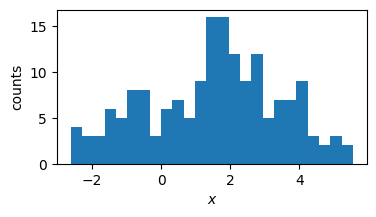

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np

data = pd.read_csv('gmm_1d.csv')

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(data['y_i'], bins=25)
ax.set(xlabel=r'$x$', ylabel='counts')
plt.show()

Let's start with the univariate data shown above. How can we model these observations, i.e., how can we model this distribution? It's certainly not normally distributed, but it looks almost like multiple normal distributions overlaid atop each other. Thus, we will try a Mixture of Gaussians model.

# Gaussian Mixture Model (GMM)

We can motivate the form of the GMM by thinking about how the data might have been generated. To generate a single observation from a mixture of $K$ Gaussians:
1. We first randomly choose which Gaussian $G_k, k \in \left\{1,2,\ldots,K\right\}$, to draw an observation from, by sampling $k \sim \text{Categorical}\left(w\right)$ where $w = \left(w_1, \ldots, w_K\right)$ is the prior probability of drawing from each of the $K$ Gaussians.
2. Then we draw the observation from the chosen Gaussian $x \sim G_k$.

Note that each $G_k$ has its own parameters $\mu_k$ and $\sigma^2_k$.

This algorithm describes *the data-generating process* that we're assuming in the GMM model. For fixed values of the parameters $\left\{ w_{1:K}, \mu_{1:K}, \sigma^2_{1:K} \right\}$, we can generate a new observation $x$ by following this procedure: 

1. $ k  \sim \text{Categorical}\left(w\right) $
2. $ x \sim G_k\left(\mu_k, \sigma^2_k\right) $


## Likelihood

In practical problems, though, we are less interested in generating data from a model with a fixed parameter set; we instead have a dataset of observations and we want to determine the parameters of the model that "best fit" the observed data. This fitting can be done using Bayesian methods. We will instead adopt the maximum likelihood estimation approach, where we pick the parameters which make the observed data the most likely. 

To do this, we need to quantify how likely a particular observation is, given a particular choice of parameters. This is the likelihood function. Given a fixed parameter set, the likelihood function will give us a measure of how likely an input observation is under our model with those parameters.

To construct the likelihood for the GMM, assume we have an observation $x$ and a fixed set of model parameters. Think back to the data generating process: $x$ is generated by choosing a cluster $k$ and then drawing $x$ from the corresponding Gaussian. The probability of drawing $x$ from Gaussian $k$ is just $G_k\left(x; \mu_k, \sigma^2_K\right)$, the pdf of the Gaussian. But we don't know which $k$ was chosen! All we know is the prior probability of choosing each of the Gaussian components, $w$. Thus, the probability of observing $x$ *at all* is 

\begin{align*}
    p\left(x \, \middle| \, w_{1:K}, \mu_{1:K}, \sigma^2_{1:K} \right) & = w_1 \mathcal{N}\left(x; \mu_1, \sigma^2_1\right) + w_2 \mathcal{N}\left(x; \mu_2, \sigma^2_2\right) + \cdots + w_K \mathcal{N}\left(x; \mu_K, \sigma^2_K\right) \\
    & = \sum_{k=1}^K w_k \mathcal{N}\left(x; \mu_k, \sigma^2_k\right) \\
\end{align*}


The likelihood for the entire observed dataset $\mathcal{D}$ is obtained by multiplying this probability over all of the data observations; this is the probability of observing the entire dataset under our model:

$$ L_{\theta}\left(\mathcal{D}\right) := \prod_{x\in \mathcal{D}} \sum_{k=1}^K w_k \mathcal{N}\left(x; \mu_k, \sigma^2\right) $$

The goal of our learning is thus to determine the parameters $\theta = \left\{ w_{1:K}, \mu_{1:K}, \sigma^2_{1:K} \right\}$ which maximize the likelihood:

$$ \theta^* = \argmax_{\theta} L_{\theta}\left(\mathcal{D}\right) $$

Since the likelihood is a product of fractions, it can become astronomically small and so we typically deal with the log-likelihood:

$$ l_{\theta}\left(\mathcal{D}\right) := \log L_{\theta}\left(\mathcal{D}\right) = \sum_{x\in \mathcal{D}} \log \left[ \sum_{k=1}^K w_k \mathcal{N}\left(x; \mu_k, \sigma^2_k\right) \right] $$

Clearly we have 

$$ \theta^* = \argmax_{\theta} l_{\theta}\left(\mathcal{D}\right) = \argmax_{\theta} L_{\theta}\left(\mathcal{D}\right) $$

Since each term in the sum is negative (the argument of the log is fractional), we can maximize the log-likelihood by maximizing each term. I will write $L_{\theta}\left(x\right)$ for the likelihood of a single data point,

$$ L_{\theta}\left(x\right) := \sum_{k=1}^K w_k \mathcal{N}\left(x; \mu_k, \sigma^2_k\right) $$

Then the learning objective here is

$$ \theta^* = \argmax_{\theta} l_{\theta}\left(\mathcal{D}\right) = \argmax_{\theta} \sum_{x\in \mathcal{D}} \log L_{\theta}\left(x\right) $$

## Gradient descent solution

Let's try to solve this by stochastic gradient ascent. We will calculate the gradient of the above objective with respect to each of the parameters.

Start by working inside of the sum:

\begin{align*}
    \frac{\partial}{\partial w_k} \sum_{x\in \mathcal{D}} \log L_{\theta} \left(x\right) & = \sum_{x\in \mathcal{D}} \frac{1}{L_{\theta}\left(x\right)} \frac{\partial}{\partial w_k} L_{\theta}\left(x\right) \\
    & = \sum_{x\in \mathcal{D}} \frac{\mathcal{N}\left(x; \mu_k, \sigma^2_k\right)}{L_{\theta}\left(x\right)}  \\
\end{align*}

\begin{align*}
    \frac{\partial}{\partial \mu_k} \sum_{x\in\mathcal{D}} \log L_{\theta}\left(x\right) & = \sum_{x\in \mathcal{D}} \frac{1}{L_{\theta}\left(x\right)} \frac{\partial}{\partial \mu_k} L_{\theta}\left(x\right) \\
    & = \sum_{x\in \mathcal{D}} \frac{1}{L_{\theta}\left(x\right)} w_k \frac{\partial}{\partial \mu_k} \mathcal{N}\left(x; \mu_k, \sigma^2_k\right) \\
    & = \sum_{x\in \mathcal{D}} \frac{w_k}{L_{\theta}\left(x\right)} \frac{\left(x-\mu_k\right)}{\sigma_k^2 \sqrt{2\pi \sigma_k^2}} \exp\left({-\frac{\left(x-\mu_k\right)^2}{2\sigma_k^2}}\right) \\
    & = \frac{w_k}{\sigma_k^2 \sqrt{2\pi \sigma_k^2}} \sum_{x\in \mathcal{D}} \frac{\left(x-\mu_k\right)}{L_{\theta}\left(x\right)} \frac{}{} \exp\left({-\frac{\left(x-\mu_k\right)^2}{2\sigma_k^2}}\right) \\
\end{align*}

\begin{align*}
    \frac{\partial}{\partial \sigma^2_k} \sum_{x\in\mathcal{D}} \log L_{\theta}\left(x\right) & = \sum_{x\in \mathcal{D}} \frac{1}{L_{\theta}\left(x\right)} \frac{\partial}{\partial \sigma^2_k} L_{\theta}\left(x\right) \\
    & = \sum_{x\in \mathcal{D}} \frac{1}{L_{\theta}\left(x\right)} w_k \frac{\partial}{\partial \sigma^2_k} \mathcal{N}\left(x; \mu_k, \sigma^2_k\right) \\
    & = \frac{w_k}{2\sqrt{2\pi}}\sum_{x\in\mathcal{D}} \frac{1}{L_{x}\left(\mathcal{D}\right)} \left[  \left(x-\mu_k\right)^2 - \sigma_k^2\right] \left(\sigma^2_k\right)^{-5/2} \exp\left( -\frac{\left(x - \mu_k\right)^2}{2\sigma_k^2} \right) \\
\end{align*}

In [5]:
K = 3
mu = np.array([1.0, 2.0, 3.0])
sigma2 = np.array([1.0, 1.0, 1.0])
p_ = np.array([ss.norm.pdf(3, loc=mu[k], scale=sigma2[k]) for k in range(K)])

w = np.array([0.25, 0.50, 0.25])

In [6]:
def L_obs(x, w, mu, sigma2):
    """Calculate the likelihood of observing a single observation x."""
    K = len(mu)
    p_ = np.array([ss.norm.pdf(x, loc=mu[k], scale=sigma2[k]) for k in range(K)])
    return p_ @ w

In [7]:
def l_batch(X, w, mu, sigma2):
    """Calculate the log-likelihood of observing batch X."""
    ll = np.sum([np.log(L_obs(x, w, mu, sigma2)) for x in X])
    return ll

In [8]:
X = np.array([1.0,1.0, 1.23])
np.exp(l_batch(X, w, mu, sigma2))

0.014606200323223732

In [9]:
def dl_batch_dw(X, w, mu, sigma2):
    K = len(mu)
    cmpt = np.zeros(K)
    denom = np.array([L_obs(x, w, mu, sigma2) for x in X])

    for k in range(K):
        num = np.array([ss.norm.pdf(x, loc=mu[k], scale=sigma2[k]) for x in X])
        cmpt[k] = np.sum(num / denom)
    return cmpt

def dl_batch_dmu(X, w, mu, sigma2):
    K = len(mu)
    cmpt = np.zeros(K)
    denom = np.array([L_obs(x, w, mu, sigma2) for x in X])

    for k in range(K):
        num = np.array([(x - mu[k]) * np.exp(- (x - mu[k])**2 / (2 * sigma2[k])) for x in X])
        cmpt[k] = np.sum(num / denom)
        cmpt[k] = cmpt[k] * w[k] / (sigma2[k] * np.sqrt(2*np.pi * sigma2[k]))
    return cmpt
    
def dl_batch_dsigma2(X, w, mu, sigma2):
    K = len(mu)
    cmpt = np.zeros(K)
    denom = np.array([L_obs(x, w, mu, sigma2) for x in X])

    for k in range(K):
        num = np.array([((x - mu[k])**2 - sigma2[k]) * (sigma2[k])**(-5/2) * np.exp(- (x - mu[k])**2 / (2* sigma2[k])) for x in X])
        cmpt[k] = np.sum(num / denom)
        cmpt[k] = cmpt[k] * w[k] / (2 * np.sqrt(2 * np.pi))
    return cmpt

In [10]:
def softmax(z):
    n = np.exp(z)
    return n / np.sum(n)

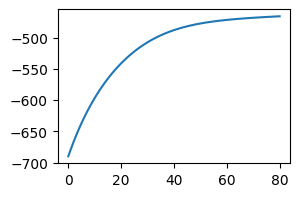

In [45]:
K = 4
mu = np.array([1.0, 2.0, 3.0, 4.0])
sigma2 = np.array([.5, .5, .5, .5])
w = np.array([0.25, 0.25, 0.25, 0.25])
X = data['y_i'].values

lls = []
lls.append(l_batch(X, w, mu, sigma2))


for epoch in range(80):

    dw = dl_batch_dw(X, w, mu, sigma2)
    dmu = dl_batch_dmu(X, w, mu, sigma2)
    dsigma2 = dl_batch_dsigma2(X, w, mu, sigma2)

    eta_w = 0.01
    eta = 0.01

    w = softmax(w + eta_w * dw / np.sum(dsigma2))

    mu = mu + eta * dmu / np.sum(dmu)
    sigma2 = sigma2 + eta * dsigma2 / np.sum(dsigma2)
    
    # reset sigma2
    if any(sigma2 > 3.0):
        sigma2 = ss.uniform(0, 1).rvs(4)
    # break
    lls.append(l_batch(X, w, mu, sigma2))

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(lls)
plt.show()

In [46]:
w

array([0.25506076, 0.24937107, 0.24751111, 0.24805705])

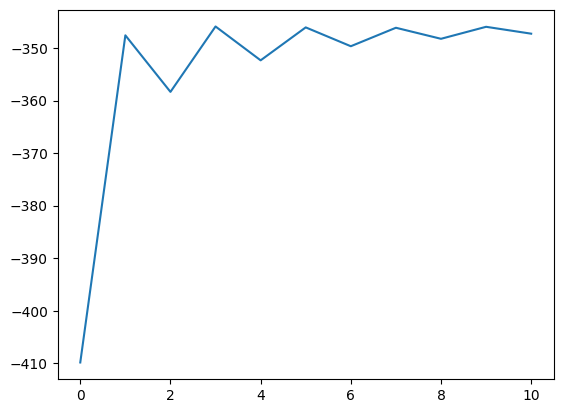

In [70]:
mu
plt.plot(lls)

In [62]:
K = 4
n_learnings = 50
X = data['y_i'].values

lls = []

for learning in range(n_learnings):
    # initialize params
    mu = ss.uniform(0,5.0).rvs(K)
    sigma2 = ss.uniform(0,2).rvs(K)
    w = ss.dirichlet(K*[1]).rvs()[0]

    for epoch in range(50):
        dw = dl_batch_dw(X, w, mu, sigma2)
        dmu = dl_batch_dmu(X, w, mu, sigma2)
        dsigma2 = dl_batch_dsigma2(X, w, mu, sigma2)

        eta_w = 0.02
        eta = 0.02

        w = softmax(w + eta_w * dw / np.sum(dsigma2))

        mu = mu + eta * dmu / np.sum(dmu)
        sigma2 = sigma2 + eta * dsigma2 / np.sum(dsigma2)
        
        # reset sigma2
        if any(sigma2 > 1.2):
            sigma2 = ss.uniform(0, 1).rvs(4)
        
    lls.append((l_batch(X, w, mu, sigma2), (w, mu, sigma2)))

# fig, ax = plt.subplots(figsize=(3,2))
# ax.plot(lls)
# plt.show()

/tmp/ipykernel_8867/536140314.py:17: RuntimeWarning: overflow encountered in exp
  num = np.array([(x - mu[k]) * np.exp(- (x - mu[k])**2 / (2 * sigma2[k])) for x in X])
/tmp/ipykernel_8867/536140314.py:19: RuntimeWarning: invalid value encountered in sqrt
  cmpt[k] = cmpt[k] * w[k] / (sigma2[k] * np.sqrt(2*np.pi * sigma2[k]))
/tmp/ipykernel_8867/536140314.py:28: RuntimeWarning: invalid value encountered in double_scalars
  num = np.array([((x - mu[k])**2 - sigma2[k]) * (sigma2[k])**(-5/2) * np.exp(- (x - mu[k])**2 / (2* sigma2[k])) for x in X])
/tmp/ipykernel_8867/536140314.py:28: RuntimeWarning: overflow encountered in exp
  num = np.array([((x - mu[k])**2 - sigma2[k]) * (sigma2[k])**(-5/2) * np.exp(- (x - mu[k])**2 / (2* sigma2[k])) for x in X])


In [63]:
max_loss, opt = sorted(lls, key=lambda x: x[0], reverse=True)[0]

In [64]:
opt

(array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]))